In [1]:
import json
import glob
import numpy as np
import matplotlib 
import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
patches = [json.load(open(x)) for x in glob.glob('patch*.json')]
grouped_patches = {x[0]['value']['name']:{p['path']:p for p in x if p['op'] == 'add'} for x in patches if 'value' in x[0]}


In [3]:
def handle_deltas(delta_up, delta_dn):
    nom_is_center = np.bitwise_or(
        np.bitwise_and(delta_up > 0, delta_dn > 0),
        np.bitwise_and(delta_up <= 0, delta_dn <= 0)
    )
    span    = (delta_dn + delta_up)
    maxdel  = np.maximum(np.abs(delta_dn),np.abs(delta_dn))
    abs_unc = np.where(nom_is_center, span, maxdel)
    return abs_unc

def process_patch(p):
    nom = np.asarray(p['value']['data'])


    #histosys
    hid = np.asarray([m['data']['hi_data'] for m in p['value']['modifiers'] if m['type'] == 'histosys'])
    lod = np.asarray([m['data']['lo_data'] for m in p['value']['modifiers'] if m['type'] == 'histosys'])
    delta_up = hid-nom
    delta_dn = nom-lod
    A = handle_deltas(delta_up,delta_dn)

    hi = np.asarray([m['data']['hi'] for m in p['value']['modifiers'] if m['type'] == 'normsys'])
    lo = np.asarray([m['data']['lo'] for m in p['value']['modifiers'] if m['type'] == 'normsys'])
    delta_up = np.asarray([h*nom-nom for h in hi])
    delta_dn = np.asarray([l*nom-nom for l in lo])
    B = handle_deltas(delta_up,delta_dn)


    delta = np.asarray([m['data'] for m in p['value']['modifiers'] if m['type'] == 'staterror'])
    delta_up = (delta/2.)
    delta_dn = (delta/2.)
    C = handle_deltas(delta_up,delta_dn)
    C = np.zeros_like(A)

    systs = np.concatenate([A,B,C])
    inquad = np.sqrt(np.sum(np.square(systs), axis=0))
    rel =  inquad/nom
    rel = np.where(nom == 0, np.ones_like(nom), rel)
    return rel,nom

# process_patch(grouped_patches['sbottom_1600_650_60']['/channels/2/samples/0'])

In [4]:
data = {x[0]['value']['name']:{p['path']:process_patch(p) for p in x if p['op'] == 'add'} for x in patches if 'value' in x[0]}

channel_names = {
    '/channels/0/samples/5': 'CRlow_cuts',
    '/channels/1/samples/5': 'CRISR_cuts',
    '/channels/2/samples/5': 'SRlow_cuts',
    '/channels/3/samples/5': 'SRlow_cuts'
}

outliers = []
for k,v in data.items():
    for kk,vv in v.items():
        for b,(r,n) in enumerate(zip(*vv)):
            if r > 1.0:
                outliers.append((k,kk,b,r,n))

print("Outliers (> 1.0):")
for o in list(reversed(sorted(outliers, key = lambda x: x[-1]))):
    print('\t',o[-1],o[-2],o[0],channel_names[o[1]],o[2])
    
missing_signal = []
# missing signal in signal region
print("Missing signal in signal region:")
for k, v in data.items():
    if not '/channels/2/samples/5' in v or not '/channels/2/samples/5' in v:
        missing_signal.append(k)
        print('\t',k)

[0.17636733] [7.76288795]
[0.20673507] [1.93172264]
[0.17579983] [23.11458969]
[0.2255741] [2.89622855]
[0.13417209] [2.82426524]
[0.30996566] [0.54037023]
[0.28879099] [1.22482204]
[2.13151137] [0.03834467]
[0.30421843] [4.50951099]
[0.19000313] [3.27578044]
[0.12049354] [3.14231086]
[0.18083812] [5.13653183]
[0.19388297] [1.15531719]
[0.17516754] [11.31984615]
[0.17641442] [2.16095519]
[0.17245729] [2.90435791]
[0.17469206] [3.64958119]
[0.18318917] [1.94488394]
[0.18483587] [3.12543988]
[0.17398633] [8.67621613]
[0.20948357] [1.42128038]
[0.17457271] [24.90456772]
[0.20639776] [2.35621786]
[0.17138573] [71.55427551]
[0.19105399] [21.39566612]
[0.1714794] [79.66110229]
[0.17603575] [17.67387199]
[0.21426853] [9.83903408]
[0.18249755] [8.07512379]
[0.17710181] [4.18163872]
[0.17709516] [4.58202171]
[0.17710782] [6.14041233]
[0.18203368] [3.35878229]
[0.21475058] [4.77783585]
[0.17188596] [10.74437141]
[0.1832214] [8.65660095]
[0.1894662] [6.35150528]
[0.18832749] [7.24610567]
[0.09613

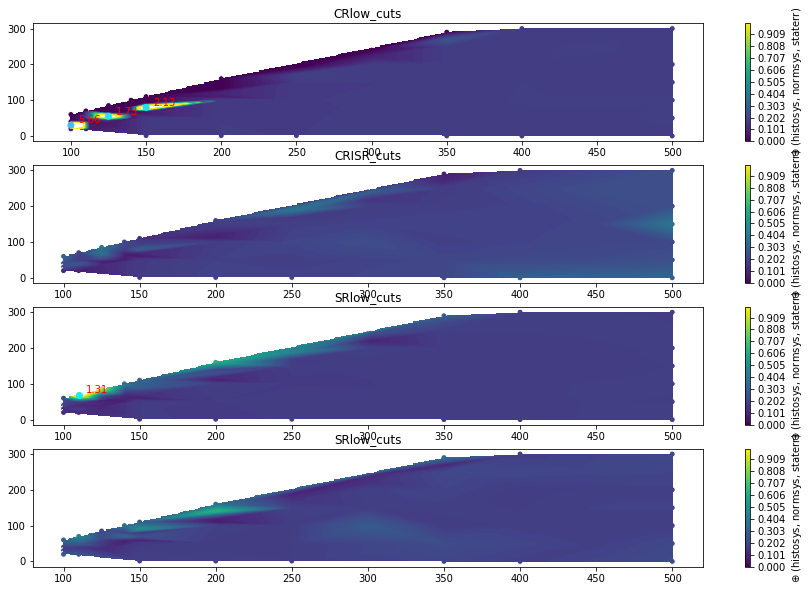

In [51]:
import scipy.interpolate
data = {x[0]['value']['name']:{p['path']:process_patch(p)[0] for p in x if p['op'] == 'add'} for x in patches if 'value' in x[0]}


f,axarr = plt.subplots(4,1)
for ichan, channel in enumerate(['/channels/0/samples/5','/channels/1/samples/5', '/channels/2/samples/5', '/channels/3/samples/5']):
    what = np.asarray(
        [[float(x.replace('p','.')) for x in k.split('WZ')[-1].split('_')[1:3]] + v.get(channel, np.array([0.0])).tolist() for k,v in data.items()
        ]
    )
    x,y = np.mgrid[100:500:100j,0:300:100j]
    for jbin in range(2,3):
        z = scipy.interpolate.griddata(what[:,:2],what[:,jbin],(x,y))
        
        vmin,vmax = 0, 1#np.log(0.001),np.log(20)
        #z = np.log(z)
        axarr[ichan].scatter(what[:,0],what[:,1], c = what[:,jbin], edgecolors='w', vmin = vmin, vmax = vmax)
        im = axarr[ichan].contourf(x,y,z, levels = np.linspace(vmin,vmax,100))
        #f.colorbar(im, cax=axarr[ichan][1])
        f.colorbar(im, ax=axarr[ichan], label='$\oplus$ (histosys, normsys, staterr)')
        axarr[ichan].set_title(channel_names[channel])
        
        out_here = np.asarray(
            [list(map(lambda x: float(x.replace('p','.')),o[0].split('WZ')[-1].split('_')[1:3])) + [o[-2]] for o in outliers
             if o[1] == channel and o[2] == jbin-2]
        )
#         print(out_here)
        
#         print(out_here.shape)
        if out_here.shape[0]:
            axarr[ichan].scatter(out_here[:,0],out_here[:,1], c = out_here[:,2], vmin = 0, vmax = 20, cmap = 'cool')
        for o in out_here:
            axarr[ichan].text(o[0]+5,o[1]+5,'{:.2f}'.format(o[2]), c='r')
f.set_size_inches(15,10)
f.savefig('plot.png')